# 尝试运行模型

Jupyter notebook 是交互式的代码IDE，非常适合新手，建议最开始在这里探索我们的模型。

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
from hydra import compose, initialize
import os

# 加载项目层面的配置
with initialize(version_base=None, config_path="../config"):
    cfg = compose(config_name="config")
os.chdir(cfg.root)

注意下面这里需要把你上面读取的参数配置文件，作为参数`parameters=cfg`输入到模型中。

In [2]:
# 从这个路径加载模型
from src.model import Model

model = Model(parameters=cfg)

2023-11-07 21:21:01.101 | DEBUG    | abses.time:_parse_time_settings:226 - start_dt: 2023-11-07T21:21:01.101680
2023-11-07 21:21:01.102 | DEBUG    | abses.time:_parse_time_settings:230 - end_dt: 100
2023-11-07 21:21:01.102 | DEBUG    | abses.time:_parse_time_settings:234 - duration: None
2023-11-07 21:21:01.103 | DEBUG    | abses.time:_parse_time_settings:238 - irregular: None
2023-11-07 21:21:01.103 | DEBUG    | abses.time:_parse_time_settings:239 - Ticking mode: tick


增加了初始的 Hunters，随机生成在地图上

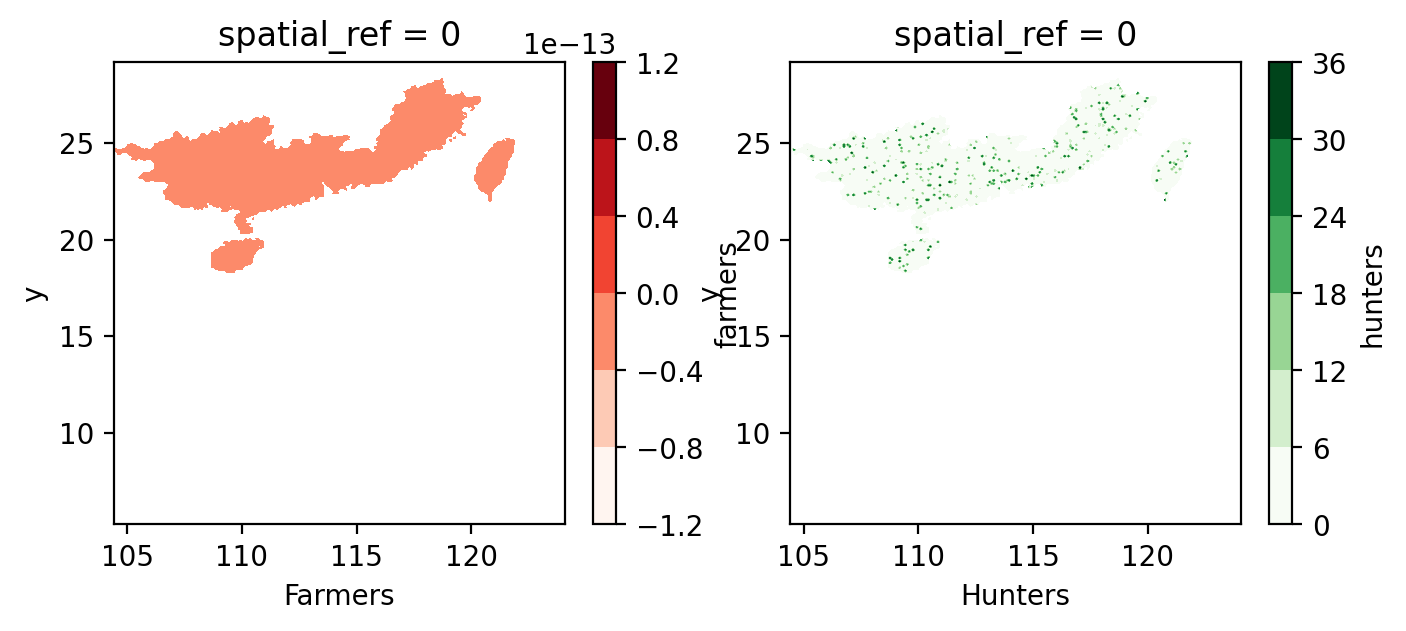

In [3]:
model.heatmap()

设置100年的话，模型的运行可能需要几分钟的时间，以此类推，模型没运算完不要太着急。完成后会自动做出下面的折线图。

tick[100] 2023-11-07 21:21:01

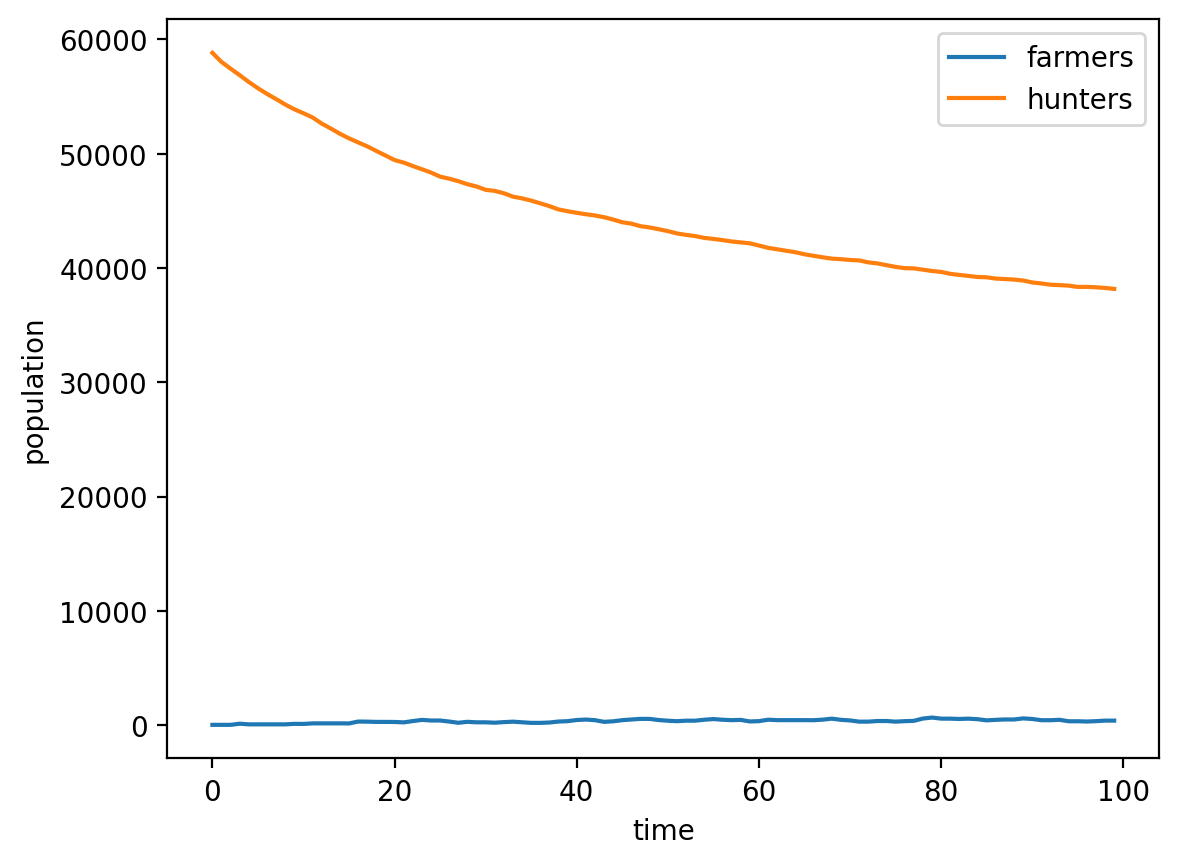

In [4]:
model.run_model()

展示主体的信息

In [5]:
agent = model.agents.to_list().random_choose()
agent.report()

unique_id         1073
breed           Hunter
size                 6
position     (13, 126)
dtype: object

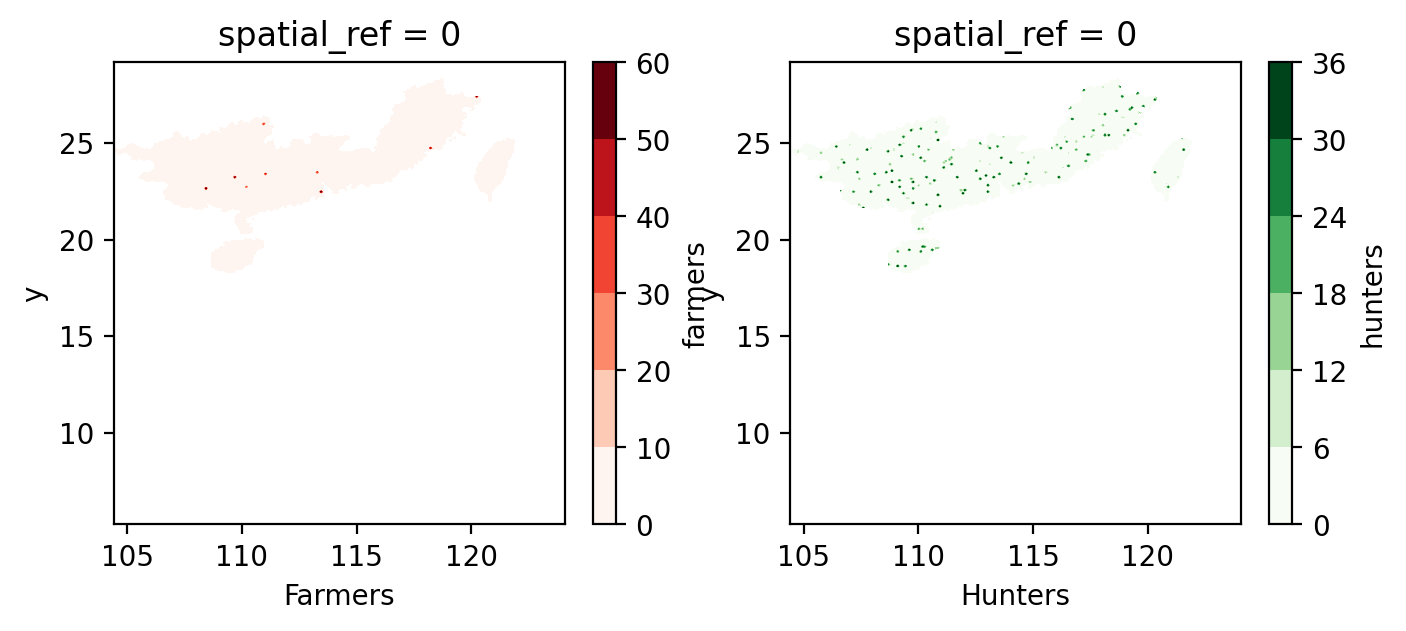

In [6]:
model.heatmap()